In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import rasterio
from osgeo import osr
import os
from osgeo import gdal
import pickle
from multiprocessing import Pool

**STOP 0: CONNECT TO GG DRIVE AND OPEN TIF FILES**

In [ ]:
# CONNECT TO GOOGLE DRIVE

from google.colab import drive
drive.mount('/content/drive')

import os
# List the contents of a directory
drive_path = '/content/drive/My Drive/'
os.listdir(drive_path)

rar_path = '/content/drive/My Drive/raster 280624-5metres (Can Tho 2004-2005).rar'

In [ ]:
# OPEN ONE TIF FILE
!pip install rasterio geopandas
import rasterio
import geopandas as gpd

# Path to the .tif file
elevation_tif = '/content/drive/My Drive/dt_elevation.tif'

# Read the .tif file using rasterio
with rasterio.open(elevation_tif) as src:
    tif_data = src.read()  # Read the raster data
    profile = src.profile  # Get the metadata profile

# Print some metadata about the .tif file
print(profile)

# Visualize the first band of the raster
import matplotlib.pyplot as plt

plt.imshow(tif_data[0], cmap='gray')
plt.title('First Band of the Elevation File')
plt.show()

In [6]:
import pyproj

# Get the path to the PROJ data directory
proj_data_dir = pyproj.datadir.get_data_dir()
print(f"PROJ data directory: {proj_data_dir}")

PROJ data directory: /Users/zeldudu/anaconda3/lib/python3.11/site-packages/pyproj/proj_dir/share/proj


In [7]:
os.environ['PROJ_LIB'] = '/Users/zeldudu/anaconda3/lib/python3.11/site-packages/pyproj/proj_dir/share/proj' 

In [11]:
# Open all tif files in a folder

def open_raster_files(folder):
    raster_files = []
    for file in os.listdir(folder):
        if file.endswith('.tif'):
            file_path = os.path.join(folder, file)
            try:
                raster = rasterio.open(file_path)
                raster_files.append(raster)
                print(f"Opened {file_path}")
            except Exception as e:
                print(f"Failed to open {file_path}: {e}")
    return raster_files

folder_path = 'FILL IN THE PATH HERE'
rasters = open_raster_files(folder_path)

**STEP 1: RESAMPLE RASTER ENVIRONMENTS**


There are 4 raster files: two of them had the shape of width': 15435, 'height': 17739, which was the desired size. Two other files were in smaller shapes that need resampling - done in QGIS

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 65535.0, 'width': 16770, 'height': 19010, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.0, 0.0, 11709548.359499998,
       0.0, -5.0, 1229094.3315999992)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 16770, 'height': 19010, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(5.0, 0.0, 11709548.359499998,
       0.0, -5.0, 1229094.3315999992)}
DataFrameE 1:
                      x             y  value
318797695  1.179338e+07  1.134047e+06  65535
318797696  1.179338e+07  1.134047e+06  65535
318797697  1.179339e+07  1.134047e+06  65535
318797698  1.179339e+07  1.134047e+06  65535
318797699  1.179340e+07  1.134047e+06  65535
DataFrameE 2:
                      x             y         value
318797695  1.179338e+07  1.134047e+06  3.400000e+38
318797696  1.179338e+07  1.134047e+06  3.400000e+38
318797697  1.179339e+07  1.134047e+06  3.400000e+38
318797698  1.179339e+07  1.134047e+06 

/Users/zeldudu/anaconda3/lib/python3.11/site-packages/matplotlib/image.py:482: RuntimeWarning: overflow encountered in cast
  vrange = np.array([vmin, vmax], dtype=scaled_dtype)


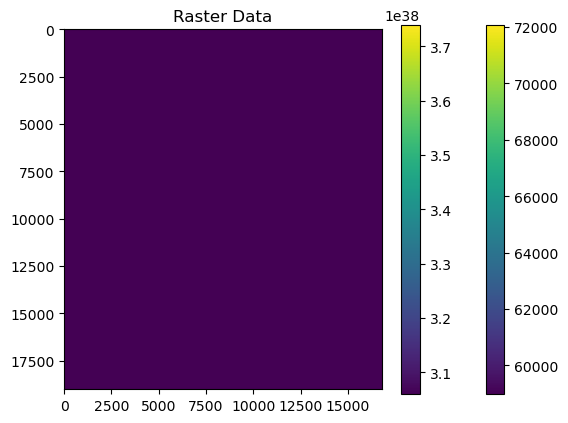

In [7]:
# Overlapped two environment files (temp and elevation) based on X and Y

folder = "/Users/zeldudu/Documents/Zalo Received Files/dongthap_rf_data/raster-environment"
raster_files = get_raster_files(folder)

dataframes_envi = []
for r in raster_files:
    df = open_raster_file(r)
    dataframes_envi.append(df)

for i, df in enumerate(dataframes_envi):
    print(f"DataFrameE {i+1}:")
    print(df.tail(5))

**Open Training Data in CSV**

In [4]:
# Open training data

df = pd.read_csv("/Users/zeldudu/Documents/Zalo Received Files/training data copy.csv")
df.dropna()
df.head()

,sample_symbol,land_use,X,Y,Tên đất theo BĐ đất cấp tỉnh,N%
0,CT 417,LUC,"105º 47' 28""","10º 13' 41""","Đất phèn tiềm tàng, điển hình",0.37
1,CT 913,LUC,"105º 53' 3""","10º 13' 25""","Đất phèn tiềm tàng, điển hình",0.21
2,CT 352,LUC,"105º 49' 16""","10º 11' 19""","Đất phù sa glây, phủ nền phèn",0.26
3,CT 49,LUC,"105º 45' 33""","10º 16' 9""","Đất phèn tiềm tàng, điển hình",0.32
4,CT 156,LUC,"105º 45' 36""","10º 13' 8""","Đất phù sa có tầng biến đổi, điển hình",0.21


In [5]:
# Convert from 2D to 3D

def convert(dms_string):
    parts = dms_string.split()
    degrees = float(parts[0].replace('º', ''))
    minutes = float(parts[1].replace("'", ''))
    seconds = float(parts[2].replace('"', ''))
    
    decimals = degrees + minutes/60 + seconds/3600
    return decimals

In [6]:
df['X_dc'] = df['X'].apply(convert)
df['Y_dc'] = df['Y'].apply(convert)
df = df.drop(columns=['X', 'Y', 'land_use', 'sample_symbol', 'Tên đất theo BĐ đất cấp tỉnh'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   N%      160 non-null    float64
 1   X_dc    160 non-null    float64
 2   Y_dc    160 non-null    float64
dtypes: float64(3)
memory usage: 3.9 KB


In [7]:
df.tail()

,N%,X_dc,Y_dc
155,0.25,105.720000,10.253056
156,0.31,105.728889,10.255833
157,0.30,105.724167,10.249167
158,0.35,105.733889,10.266389
159,0.34,105.733889,10.263056


In [4]:
from osgeo import osr, gdal

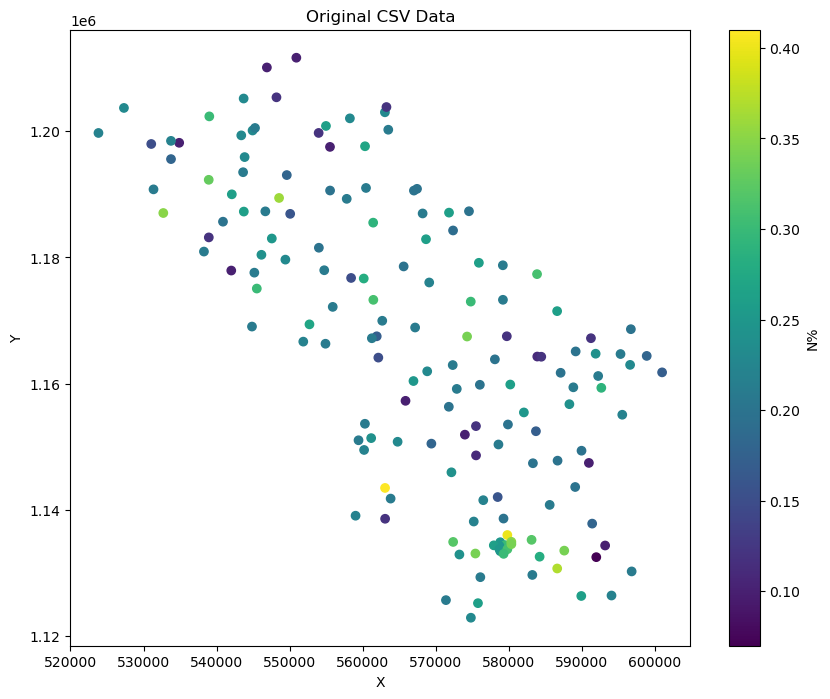

In [22]:
# Visualize the original data
plt.figure(figsize=(10, 8))
plt.scatter(df['X'], df['Y'], c=df['N%'], cmap='viridis')
plt.colorbar(label='N%')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original CSV Data')
plt.show()

**STEP 2: TRAINING DATA PROCESSING**

Training data to raster values:
- load tif file using gdal
- transform coordinates from EPSG:4326 to EPSG:3857
- transform EPSG:3857 to coordinate system (columns and rows)
- opens each raster file and extracts the values at the pixel locations corresponding to each datapoint in the training data.

In [10]:
tif_path = "/Users/zeldudu/Documents/Zalo Received Files/dongthap_rf_data/raster 280624-5metres (Dong Thap)/dt_paddyfield.tif"
dataset = gdal.Open(tif_path)

# Get the geotransformation of the raster dataset
geotransform = dataset.GetGeoTransform()
print("GeoTransform:", geotransform)

GeoTransform: (11709548.359499998, 5.0, 0.0, 1229094.3315999992, 0.0, -5.0)


In [11]:
from pyproj import Transformer

training_data = pd.read_csv("/Users/zeldudu/Documents/training_data_new.csv")

# Convert coordinates from EPSG:4326 (lat/lon) to EPSG:3857
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)

# Apply the transformation
training_data['X_3857'], training_data['Y_3857'] = zip(*training_data.apply(lambda row: transformer.transform(row['X_dc'], row['Y_dc']), axis=1))
print(training_data[['X_dc', 'Y_dc', 'X_3857', 'Y_3857']].head())

         X_dc       Y_dc        X_3857        Y_3857
0  105.791111  10.228056  1.177661e+07  1.144678e+06
1  105.884167  10.223611  1.178697e+07  1.144175e+06
2  105.821111  10.188611  1.177995e+07  1.140216e+06
3  105.759167  10.269167  1.177306e+07  1.149328e+06
4  105.760000  10.218889  1.177315e+07  1.143641e+06


In [12]:
# Convert EPSG:3857 to pixel coordinates (column, row) in the raster
def geo_to_pixel(x_3857, y_3857, geotransform):
    x_origin = geotransform[0]
    y_origin = geotransform[3]
    pixel_width = geotransform[1]
    pixel_height = geotransform[5]

    col = int((x_3857 - x_origin) / pixel_width)
    row = int((y_3857 - y_origin) / pixel_height)
    
    return col, row

# Apply this function to each transformed coordinates
training_data['col'], training_data['row'] = zip(*training_data.apply(lambda row: geo_to_pixel(row['X_3857'], row['Y_3857'], geotransform), axis=1))

print(training_data[['X_3857', 'Y_3857', 'col', 'row']].head())

         X_3857        Y_3857    col    row
0  1.177661e+07  1.144678e+06  13412  16883
1  1.178697e+07  1.144175e+06  15484  16983
2  1.177995e+07  1.140216e+06  14080  17775
3  1.177306e+07  1.149328e+06  12701  15953
4  1.177315e+07  1.143641e+06  12720  17090


In [18]:
import rasterio

# List of TIFF file paths and corresponding column names
tiff_files = [
    ("/Users/zeldudu/Documents/Zalo Received Files/dongthap_rf_data/raster 280624-5metres (Dong Thap)/dt_soilclass.tif", "soilclass"),
    ("/Users/zeldudu/Documents/Zalo Received Files/dongthap_rf_data/raster 280624-5metres (Dong Thap)/dt_paddyfield.tif", "paddyfield"),
    ("/Users/zeldudu/Downloads/dt_elevation_5x5.tif", "elevation"),
    ("/Users/zeldudu/Downloads/dt_temp_5x5.tif", "temp")
]

# Loop through each TIFF file and extract the raster values
for tiff_path, column_name in tiff_files:
    with rasterio.open(tiff_path) as src:
        # Extract the values
        training_data[column_name] = [
            src.read(1)[row, col] if 0 <= col < src.width and 0 <= row < src.height else None
            for col, row in zip(training_data['col'], training_data['row'])
        ]

output_path = '/Users/zeldudu/Documents/training_data_UPDATED.csv'
training_data.to_csv(output_path, index=False)

print(training_data.head())

     N%        X_3857        Y_3857    col    row  soilclass  paddyfield  \
0  0.37  1.177661e+07  1.144678e+06  13412  16883         11           1   
1  0.21  1.178697e+07  1.144175e+06  15484  16983          0           1   
2  0.26  1.177995e+07  1.140216e+06  14080  17775          4           1   
3  0.32  1.177306e+07  1.149328e+06  12701  15953          0           0   
4  0.21  1.177315e+07  1.143641e+06  12720  17090          0           0   

   elevation  temp  
0        3.5  6796  
1        1.8  7261  
2        2.2  6586  
3        4.1  6757  
4        3.2  6741  


In [78]:
#training_data = pd.read_csv("/Users/zeldudu/Documents/training_data_UPDATED.csv")
#training_data = training_data.drop(columns=["col", "row", "X_3857", "Y_3857"])

# Filter data
training_data = training_data[training_data["paddyfield"]==1]
training_data = training_data[training_data["soilclass"]!=0]
print(training_data.tail(10), training_data.shape)

       N%  soilclass  paddyfield  elevation  temp
144  0.20          1           1        3.8  5945
145  0.21          1           1        4.2  5637
146  0.22         11           1        4.1  5424
147  0.26          1           1        3.2  6094
150  0.25          5           1        3.8  6612
151  0.30         11           1        4.4  6944
152  0.25         11           1        4.3  6745
155  0.25         11           1        4.0  6680
157  0.30         11           1        4.1  6869
158  0.35          1           1        3.4  6759 (102, 5)


In [80]:
# Correlation matrix between variables

corr = training_data.drop(columns=["paddyfield"]).corr()
corr.style.background_gradient(cmap='coolwarm')

,N%,soilclass,elevation,temp
N%,1.000000,-0.175787,-0.299375,0.223342
soilclass,-0.175787,1.000000,0.245094,-0.123494
elevation,-0.299375,0.245094,1.000000,-0.341102
temp,0.223342,-0.123494,-0.341102,1.000000


**STEP 3: RANDOM FOREST MODEL**

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline

In [1]:
# Identifying target and features
target = "N%"
df = training_data
X = df.drop(columns=["N%", "temp", "paddyfield"])
Y = df[target]

NameError: name 'training_data' is not defined

In [82]:
# Train size = 0.7, test size = 0.3

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size = 0.3, random_state = 42
)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (71, 2)
y_train shape: (71,)
X_test shape: (31, 2)
y_test shape: (31,)


In [83]:
# Create ML pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ["elevation"]),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ["soilclass"])
    ]
)

clf = make_pipeline(
        preprocessor,
        RandomForestRegressor(random_state=42)
)
print(clf)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['elevation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['soilclass'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])


In [84]:
# Creating a data pipeline
clf = make_pipeline(
        preprocessor,
        RandomForestRegressor(random_state=42)
)
print(clf)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['elevation']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['soilclass'])])),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])


In [85]:
# Create a dictionary with the range of hyperparameters
params = {
    "randomforestregressor__n_estimators": [20, 50, 100, 200],
    "randomforestregressor__max_depth": [10, 20, 30],
    "randomforestregressor__min_samples_split": [2, 5, 10],
    "randomforestregressor__min_samples_leaf": [1, 2, 4]
}

**1. Grid Search with OneHotEncoder**

In [86]:
# Model using Grid Search

model = GridSearchCV(
    clf,
    param_grid = params,
    cv = 10,
    n_jobs = -1,
    verbose = 1
)
model.fit(X_train, y_train)

Fitting 10 folds for each of 108 candidates, totalling 1080 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('num',
                                                                         'passthrough',
                                                                         ['elevation']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['soilclass'])])),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [10, 20, 30],
                         'randomforestregressor__min_samples_leaf': [1, 2, 4],
                         'randomforestregressor__min_samples_split': [2, 5, 10],
                         'randomforestregressor__n_estimators': [20, 50, 100,
                                                                 200]},
             verbose=1)

In [59]:
# Extract best hyperparameters
model.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__min_samples_leaf': 1,
 'randomforestregressor__min_samples_split': 5,
 'randomforestregressor__n_estimators': 100}

In [48]:
cv_results = pd.DataFrame(model.cv_results_)
cv_results.head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_randomforestregressor__max_depth,param_randomforestregressor__min_samples_leaf,param_randomforestregressor__min_samples_split,param_randomforestregressor__n_estimators,params,split0_test_score,...,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.034448,0.017387,0.006529,0.002666,10,1,2,20,"{'randomforestregressor__max_depth': 10, 'rand...",0.220433,...,-1.611763,-1.468259,0.279190,-0.147771,0.516612,-0.333477,-2.079726,-0.560468,0.882330,37
1,0.037536,0.009776,0.003908,0.002192,10,1,2,50,"{'randomforestregressor__max_depth': 10, 'rand...",0.246215,...,-2.183400,-1.150102,0.390998,-0.106364,0.573895,-0.230434,-1.912325,-0.553001,0.950303,35
2,0.066983,0.012024,0.004161,0.001976,10,1,2,100,"{'randomforestregressor__max_depth': 10, 'rand...",0.243461,...,-2.580782,-0.787139,0.368984,0.013936,0.578582,-0.275706,-1.932611,-0.555761,1.013344,36
3,0.120068,0.008309,0.007344,0.003055,10,1,2,200,"{'randomforestregressor__max_depth': 10, 'rand...",0.235702,...,-2.535462,-0.842762,0.319348,-0.086774,0.603978,-0.260300,-1.908973,-0.551298,0.990638,34
4,0.014834,0.003388,0.002616,0.001641,10,1,5,20,"{'randomforestregressor__max_depth': 10, 'rand...",0.171194,...,-1.070957,-1.583508,0.033280,-0.328542,0.442579,-0.248640,-1.739605,-0.525486,0.727322,12
5,0.028790,0.004752,0.003277,0.001802,10,1,5,50,"{'randomforestregressor__max_depth': 10, 'rand...",0.170124,...,-1.272858,-1.597970,0.173953,-0.177023,0.551933,-0.323076,-1.618847,-0.501422,0.765700,5
6,0.055604,0.004028,0.008680,0.001690,10,1,5,100,"{'randomforestregressor__max_depth': 10, 'rand...",0.160000,...,-1.586446,-1.412047,0.122396,-0.005461,0.611619,-0.374001,-1.524002,-0.490605,0.775424,1
7,0.112783,0.005541,0.007216,0.003003,10,1,5,200,"{'randomforestregressor__max_depth': 10, 'rand...",0.150090,...,-1.581860,-1.329708,0.081061,-0.108986,0.647005,-0.383977,-1.624485,-0.496270,0.772817,2
8,0.014526,0.002997,0.003051,0.001511,10,1,10,20,"{'randomforestregressor__max_depth': 10, 'rand...",0.055918,...,-0.396549,-2.124377,-0.112814,-0.336420,0.167646,-0.266587,-1.482476,-0.529258,0.704099,13
9,0.028248,0.004309,0.004546,0.002838,10,1,10,50,"{'randomforestregressor__max_depth': 10, 'rand...",0.089288,...,-0.589817,-2.286643,-0.032065,-0.278461,0.271819,-0.235230,-1.556324,-0.546680,0.779004,28


In [61]:
# Accuracy score
acc_train = model.score(X_train, y_train)
acc_test = model.score(X_test, y_test)

print("Training Accuracy:", round(acc_train, 4))
print("Test Accuracy:", round(acc_test, 4))

Training Accuracy: 0.6646
Test Accuracy: -0.2209


dict_keys(['columntransformer', 'randomforestregressor'])


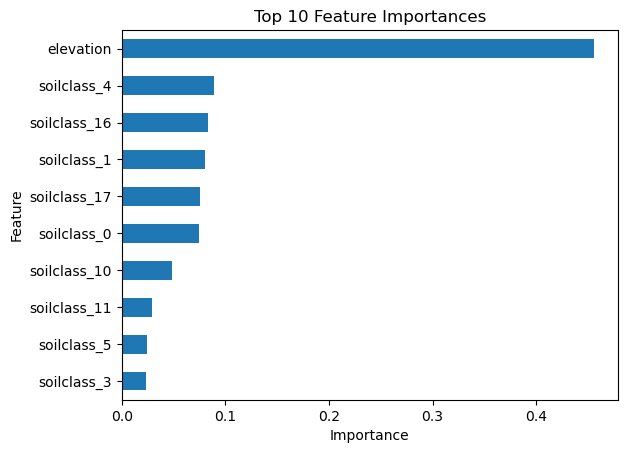

In [60]:
original_features = X_train.columns

preprocessor = model.best_estimator_.named_steps['columntransformer']
# Extract the names of the features after preprocessing
if isinstance(preprocessor, ColumnTransformer):
    transformed_features = []
    for name, transformer, columns in preprocessor.transformers_:
        if hasattr(transformer, 'get_feature_names_out'):
            transformed_features.extend(transformer.get_feature_names_out(columns))
        else:
            transformed_features.extend(columns)
else:
    transformed_features = original_features

# Extract the best RandomForestRegressor model from the pipeline
best_rf = model.best_estimator_.named_steps['randomforestregressor']

# Extract importances from the RandomForestRegressor
importances = best_rf.feature_importances_

# Create a series with the transformed feature names and importances
feat_imp = pd.Series(importances, index=transformed_features).sort_values()

# Plot the 10 most important features
feat_imp.tail(10).plot(kind="barh")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importances")
plt.show()


**2. Grid Search without OneHotEncoder**

In [75]:
# Model without OneHotEncoder

clf2 = RandomForestRegressor(random_state=42)

# Create a dictionary with the range of hyperparameters
params = {
    "n_estimators": [20, 50, 80, 100, 200],
    "max_depth": [10, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

model = GridSearchCV(
    clf2,
    param_grid = params,
    cv = 10,
    n_jobs = -1,
    verbose = 1
)
model.fit(X_train, y_train)
print(model.best_params_)
print("Training accuracy:", model.score(X_train, y_train))
print("Testing accuracy:", model.score(X_test, y_test))

Fitting 10 folds for each of 135 candidates, totalling 1350 fits
{'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 20}
Training accuracy: 0.29136921716911435
Testing accuracy: -0.009792630443346884


**3. Randomized Search without OneHotEncoder**

In [73]:
# Model using RandomizedSearch

from sklearn.model_selection import RandomizedSearchCV
params = {
    "n_estimators": [20, 50, 100, 200, 500],
    "max_depth": [5, 10, 20, 30, None],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 2, 4, 10],
    "max_features": ['sqrt', 'log2'],
    "bootstrap": [True, False]
}

# Randomized Search to find the best combination
model = RandomizedSearchCV(
    clf2,
    param_distributions=params,
    cv=10,
    n_iter=100,  # Number of random combinations to try
    n_jobs=-1,
    verbose=1,
    random_state=42
)

model.fit(X_train, y_train)
print(model.best_params_)
print("Training accuracy:", model.score(X_train, y_train))
print("Testing accuracy:", model.score(X_test, y_test))

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
Training accuracy: 0.5261120556905696
Testing accuracy: -0.08587282752683434
